# Clasificación de Imágenes con Modelos Pre-entrenados

Este notebook permite clasificar una imagen dada utilizando cualquiera de los modelos pre-entrenados disponibles en la carpeta `models/`.

## Modelos Disponibles:

### Modelos CNN (Redes Neuronales Convolucionales):
- `background_cnn_classifier_fast.h5` - Modelo CNN rápido
- `background_cnn_classifier_full.h5` - Modelo CNN completo

### Modelos de Machine Learning Tradicional:
- `background_logistic_regression_classifier_cv.pkl` - Regresión Logística
- `background_random_forest_classifier_features_full.pkl` - Random Forest (completo)
- `background_random_forest_classifier_features.pkl` - Random Forest (rápido)
- `background_svc_classifier_cv.pkl` - Support Vector Classifier

## Clases de Clasificación:
- **0**: Fondo inapropiado (no blanco/crema)
- **1**: Fondo apropiado (blanco/crema)

---

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import joblib
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import warnings
from PIL import Image
import requests
from io import BytesIO
import sys

# Configurar warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Configuración y Carga de Modelos

In [2]:
# Configurar rutas
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
models_dir = project_root / "models"

print(f"📁 Directorio del proyecto: {project_root}")
print(f"📁 Directorio de modelos: {models_dir}")

# Verificar que el directorio de modelos existe
if not models_dir.exists():
    print(f"❌ Error: El directorio {models_dir} no existe")
    print("Por favor, ejecuta primero los scripts de entrenamiento para generar los modelos.")
else:
    print("✅ Directorio de modelos encontrado")
    
    # Listar modelos disponibles
    model_files = list(models_dir.glob("*"))
    print(f"\n📋 Modelos disponibles ({len(model_files)}):")
    for i, model_file in enumerate(model_files, 1):
        print(f"   {i}. {model_file.name}")

📁 Directorio del proyecto: c:\Users\jucas\OneDrive\Escritorio\MELI\MELI_CVC_20220719_prueba_tecnica\image-classification-app
📁 Directorio de modelos: c:\Users\jucas\OneDrive\Escritorio\MELI\MELI_CVC_20220719_prueba_tecnica\image-classification-app\models
✅ Directorio de modelos encontrado

📋 Modelos disponibles (6):
   1. background_cnn_classifier_fast.h5
   2. background_cnn_classifier_full.h5
   3. background_logistic_regression_classifier_cv.pkl
   4. background_random_forest_classifier_features.pkl
   5. background_random_forest_classifier_features_full.pkl
   6. background_svc_classifier_cv.pkl


## 2. Clase para Cargar y Usar Modelos

In [3]:
class ImageClassifier:
    """
    Clase para cargar y usar modelos de clasificación de imágenes.
    """
    
    def __init__(self, models_dir):
        self.models_dir = Path(models_dir)
        self.loaded_models = {}
        self.model_info = {
            'background_cnn_classifier_fast.h5': {
                'type': 'cnn',
                'name': 'CNN Rápido',
                'description': 'Red neuronal convolucional optimizada para velocidad'
            },
            'background_cnn_classifier_full.h5': {
                'type': 'cnn',
                'name': 'CNN Completo',
                'description': 'Red neuronal convolucional con arquitectura completa'
            },
            'background_logistic_regression_classifier_cv.pkl': {
                'type': 'ml',
                'name': 'Regresión Logística',
                'description': 'Modelo de regresión logística con validación cruzada'
            },
            'background_random_forest_classifier_features_full.pkl': {
                'type': 'ml',
                'name': 'Random Forest Completo',
                'description': 'Random Forest con parámetros optimizados'
            },
            'background_random_forest_classifier_features.pkl': {
                'type': 'ml',
                'name': 'Random Forest Rápido',
                'description': 'Random Forest optimizado para velocidad'
            },
            'background_svc_classifier_cv.pkl': {
                'type': 'ml',
                'name': 'Support Vector Classifier',
                'description': 'SVC con validación cruzada'
            }
        }
    
    def load_model(self, model_filename):
        """
        Cargar un modelo específico.
        
        Args:
            model_filename (str): Nombre del archivo del modelo
        """
        model_path = self.models_dir / model_filename
        
        if not model_path.exists():
            raise FileNotFoundError(f"Modelo no encontrado: {model_path}")
        
        try:
            if model_filename.endswith('.h5'):
                # Cargar modelo CNN
                model = keras.models.load_model(model_path)
                print(f"✅ Modelo CNN cargado: {model_filename}")
            elif model_filename.endswith('.pkl'):
                # Cargar modelo ML tradicional
                model = joblib.load(model_path)
                print(f"✅ Modelo ML cargado: {model_filename}")
            else:
                raise ValueError(f"Formato de archivo no soportado: {model_filename}")
            
            self.loaded_models[model_filename] = model
            return model
            
        except Exception as e:
            print(f"❌ Error cargando modelo {model_filename}: {e}")
            raise
    
    def get_model_info(self, model_filename):
        """
        Obtener información sobre un modelo.
        """
        return self.model_info.get(model_filename, {
            'type': 'unknown',
            'name': 'Modelo Desconocido',
            'description': 'Información no disponible'
        })
    
    def list_available_models(self):
        """
        Listar todos los modelos disponibles.
        """
        available_models = []
        for model_file in self.models_dir.glob("*"):
            if model_file.is_file():
                available_models.append(model_file.name)
        return available_models

# Crear instancia del clasificador
classifier = ImageClassifier(models_dir)
print("✅ Clasificador inicializado")

✅ Clasificador inicializado


## 3. Funciones de Preprocesamiento de Imágenes

In [4]:
def load_image_from_path(image_path, target_size=(224, 224)):
    """
    Cargar imagen desde ruta local.
    
    Args:
        image_path (str): Ruta a la imagen
        target_size (tuple): Tamaño objetivo para redimensionar
    
    Returns:
        np.array: Imagen preprocesada
    """
    try:
        # Cargar imagen con OpenCV
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"No se pudo cargar la imagen: {image_path}")
        
        # Convertir BGR a RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Redimensionar
        image_resized = cv2.resize(image_rgb, target_size)
        
        # Normalizar a [0, 1]
        image_normalized = image_resized.astype(np.float32) / 255.0
        
        return image_normalized
        
    except Exception as e:
        print(f"❌ Error cargando imagen: {e}")
        raise

def load_image_from_url(image_url, target_size=(224, 224)):
    """
    Cargar imagen desde URL.
    
    Args:
        image_url (str): URL de la imagen
        target_size (tuple): Tamaño objetivo para redimensionar
    
    Returns:
        np.array: Imagen preprocesada
    """
    try:
        # Descargar imagen
        response = requests.get(image_url)
        response.raise_for_status()
        
        # Convertir a imagen PIL
        image_pil = Image.open(BytesIO(response.content))
        
        # Convertir a array numpy
        image_array = np.array(image_pil)
        
        # Si es RGBA, convertir a RGB
        if image_array.shape[2] == 4:
            image_array = image_array[:, :, :3]
        
        # Redimensionar
        image_resized = cv2.resize(image_array, target_size)
        
        # Normalizar a [0, 1]
        image_normalized = image_resized.astype(np.float32) / 255.0
        
        return image_normalized
        
    except Exception as e:
        print(f"❌ Error cargando imagen desde URL: {e}")
        raise

def preprocess_for_cnn(image, target_size=(224, 224)):
    """
    Preprocesar imagen para modelos CNN.
    
    Args:
        image (np.array): Imagen original
        target_size (tuple): Tamaño objetivo
    
    Returns:
        np.array: Imagen preprocesada para CNN
    """
    # Redimensionar si es necesario
    if image.shape[:2] != target_size:
        image = cv2.resize(image, target_size)
    
    # Normalizar a [0, 1]
    if image.max() > 1.0:
        image = image.astype(np.float32) / 255.0
    
    # Agregar dimensión de batch
    image_batch = np.expand_dims(image, axis=0)
    
    return image_batch

def preprocess_for_ml(image, target_size=(224, 224)):
    """
    Preprocesar imagen para modelos ML tradicionales.
    
    Args:
        image (np.array): Imagen original
        target_size (tuple): Tamaño objetivo
    
    Returns:
        np.array: Características extraídas
    """
    # Redimensionar si es necesario
    if image.shape[:2] != target_size:
        image = cv2.resize(image, target_size)
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Aplanar la imagen
    flattened = gray.flatten()
    
    # Agregar dimensión de muestra
    features = np.expand_dims(flattened, axis=0)
    
    return features

print("✅ Funciones de preprocesamiento definidas")

✅ Funciones de preprocesamiento definidas


## 4. Función Principal de Clasificación

In [5]:
def classify_image(image_input, model_filename, show_image=True):
    """
    Clasificar una imagen usando un modelo específico.
    
    Args:
        image_input (str or np.array): Ruta de imagen, URL, o array de imagen
        model_filename (str): Nombre del archivo del modelo
        show_image (bool): Si mostrar la imagen
    
    Returns:
        dict: Resultados de la clasificación
    """
    try:
        # Obtener información del modelo
        model_info = classifier.get_model_info(model_filename)
        print(f"\n🔍 Usando modelo: {model_info['name']}")
        print(f"📝 Descripción: {model_info['description']}")
        
        # Cargar modelo si no está cargado
        if model_filename not in classifier.loaded_models:
            model = classifier.load_model(model_filename)
        else:
            model = classifier.loaded_models[model_filename]
        
        # Cargar y preprocesar imagen
        if isinstance(image_input, str):
            if image_input.startswith('http'):
                image = load_image_from_url(image_input)
            else:
                image = load_image_from_path(image_input)
        else:
            image = image_input
        
        # Mostrar imagen si se solicita
        if show_image:
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.title(f"Imagen a clasificar")
            plt.axis('off')
            plt.show()
        
        # Preprocesar según el tipo de modelo
        if model_info['type'] == 'cnn':
            processed_image = preprocess_for_cnn(image)
        else:
            processed_image = preprocess_for_ml(image)
        
        # Realizar predicción
        if model_info['type'] == 'cnn':
            # Modelo CNN
            predictions = model.predict(processed_image, verbose=0)
            predicted_class = np.argmax(predictions[0])
            confidence = float(predictions[0][predicted_class])
            probabilities = {
                'Fondo Inapropiado (0)': float(predictions[0][0]),
                'Fondo Apropiado (1)': float(predictions[0][1])
            }
        else:
            # Modelo ML tradicional
            predicted_class = model.predict(processed_image)[0]
            probabilities_raw = model.predict_proba(processed_image)[0]
            confidence = float(max(probabilities_raw))
            probabilities = {
                'Fondo Inapropiado (0)': float(probabilities_raw[0]),
                'Fondo Apropiado (1)': float(probabilities_raw[1])
            }
        
        # Interpretar resultado
        class_names = {
            0: 'Fondo Inapropiado',
            1: 'Fondo Apropiado (Blanco/Crema)'
        }
        
        result = {
            'predicted_class': int(predicted_class),
            'class_name': class_names[predicted_class],
            'confidence': confidence,
            'probabilities': probabilities,
            'model_used': model_info['name'],
            'model_type': model_info['type']
        }
        
        # Mostrar resultados
        print(f"\n📊 Resultados de la clasificación:")
        print(f"🎯 Clase predicha: {result['class_name']} (Clase {predicted_class})")
        print(f"🎯 Confianza: {confidence:.4f} ({confidence*100:.2f}%)")
        print(f"\n📈 Probabilidades por clase:")
        for class_name, prob in probabilities.items():
            print(f"   {class_name}: {prob:.4f} ({prob*100:.2f}%)")
        
        return result
        
    except Exception as e:
        print(f"❌ Error en la clasificación: {e}")
        raise

print("✅ Función de clasificación definida")

✅ Función de clasificación definida


## 5. Ejemplo de Uso - Clasificar una Imagen

In [6]:
# Listar modelos disponibles
available_models = classifier.list_available_models()
print("📋 Modelos disponibles:")
for i, model in enumerate(available_models, 1):
    info = classifier.get_model_info(model)
    print(f"   {i}. {model} - {info['name']} ({info['type'].upper()})")

# Seleccionar un modelo para el ejemplo (puedes cambiar este)
selected_model = available_models[0] if available_models else None

if selected_model:
    print(f"\n🎯 Modelo seleccionado para el ejemplo: {selected_model}")
else:
    print("\n❌ No hay modelos disponibles. Por favor, ejecuta primero los scripts de entrenamiento.")

📋 Modelos disponibles:
   1. background_cnn_classifier_fast.h5 - CNN Rápido (CNN)
   2. background_cnn_classifier_full.h5 - CNN Completo (CNN)
   3. background_logistic_regression_classifier_cv.pkl - Regresión Logística (ML)
   4. background_random_forest_classifier_features.pkl - Random Forest Rápido (ML)
   5. background_random_forest_classifier_features_full.pkl - Random Forest Completo (ML)
   6. background_svc_classifier_cv.pkl - Support Vector Classifier (ML)

🎯 Modelo seleccionado para el ejemplo: background_cnn_classifier_fast.h5


### Opción 1: Clasificar imagen desde URL (ejemplo con imagen de MercadoLibre)

🔍 Clasificando imagen desde URL: https://http2.mlstatic.com/D_869404-MLB50031636104_052022-F.jpg

🔍 Usando modelo: CNN Rápido
📝 Descripción: Red neuronal convolucional optimizada para velocidad


✅ Modelo CNN cargado: background_cnn_classifier_fast.h5


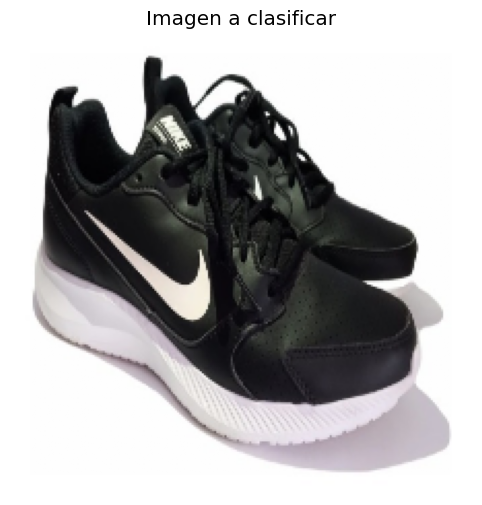


📊 Resultados de la clasificación:
🎯 Clase predicha: Fondo Apropiado (Blanco/Crema) (Clase 1)
🎯 Confianza: 0.8672 (86.72%)

📈 Probabilidades por clase:
   Fondo Inapropiado (0): 0.1328 (13.28%)
   Fondo Apropiado (1): 0.8672 (86.72%)


In [7]:
# Ejemplo con URL de imagen de MercadoLibre
# Puedes cambiar esta URL por cualquier imagen que quieras clasificar
example_url = "https://http2.mlstatic.com/D_869404-MLB50031636104_052022-F.jpg"

if selected_model:
    try:
        print(f"🔍 Clasificando imagen desde URL: {example_url}")
        result = classify_image(example_url, selected_model, show_image=True)
    except Exception as e:
        print(f"❌ Error: {e}")
        print("💡 Tip: Verifica que la URL sea válida y que tengas conexión a internet.")
else:
    print("❌ No hay modelos disponibles para clasificar.")

### Opción 2: Clasificar imagen desde archivo local

🔍 Clasificando imagen local: ../data/validation_images/MLA1140113687_958752-MLA50163693917_062022.jpg

🔍 Usando modelo: CNN Rápido
📝 Descripción: Red neuronal convolucional optimizada para velocidad


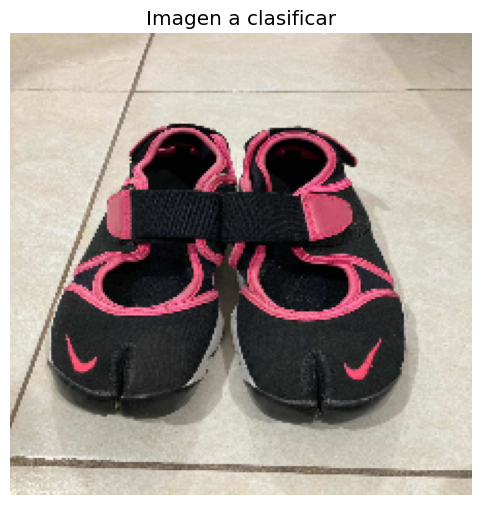


📊 Resultados de la clasificación:
🎯 Clase predicha: Fondo Inapropiado (Clase 0)
🎯 Confianza: 0.9984 (99.84%)

📈 Probabilidades por clase:
   Fondo Inapropiado (0): 0.9984 (99.84%)
   Fondo Apropiado (1): 0.0016 (0.16%)


In [14]:
#Ejemplo con imagen local (descomenta y ajusta la ruta según tu caso)
image_path = "../data/validation_images/MLA1140113687_958752-MLA50163693917_062022.jpg"
# 
if selected_model and Path(image_path).exists():
    try:
        print(f"🔍 Clasificando imagen local: {image_path}")
        result = classify_image(image_path, selected_model, show_image=True)
    except Exception as e:
        print(f"❌ Error: {e}")
elif selected_model:
    print(f"❌ Archivo no encontrado: {image_path}")
else:
    print("❌ No hay modelos disponibles para clasificar.")

#print("💡 Para usar esta opción, descomenta el código y ajusta la ruta de la imagen.")

## 6. Comparar Múltiples Modelos

In [15]:
def compare_models(image_input, model_filenames=None):
    """
    Comparar la clasificación de una imagen usando múltiples modelos.
    
    Args:
        image_input (str or np.array): Imagen a clasificar
        model_filenames (list): Lista de modelos a comparar
    """
    if model_filenames is None:
        model_filenames = classifier.list_available_models()
    
    print(f"🔍 Comparando {len(model_filenames)} modelos para la misma imagen...")
    
    results = []
    
    for model_filename in model_filenames:
        try:
            print(f"\n{'='*60}")
            result = classify_image(image_input, model_filename, show_image=False)
            results.append({
                'model': model_filename,
                'model_name': result['model_used'],
                'model_type': result['model_type'],
                'predicted_class': result['predicted_class'],
                'class_name': result['class_name'],
                'confidence': result['confidence'],
                'probabilities': result['probabilities']
            })
        except Exception as e:
            print(f"❌ Error con modelo {model_filename}: {e}")
    
    # Mostrar resumen comparativo
    if results:
        print(f"\n{'='*80}")
        print("📊 RESUMEN COMPARATIVO")
        print(f"{'='*80}")
        
        # Crear DataFrame para mejor visualización
        df_results = pd.DataFrame(results)
        
        print("\n🎯 Predicciones por modelo:")
        for _, row in df_results.iterrows():
            print(f"   {row['model_name']:25s} | {row['class_name']:25s} | Confianza: {row['confidence']:.4f}")
        
        # Estadísticas
        print(f"\n📈 Estadísticas:")
        print(f"   Modelos que predicen 'Fondo Apropiado': {sum(df_results['predicted_class'] == 1)}/{len(df_results)}")
        print(f"   Modelos que predicen 'Fondo Inapropiado': {sum(df_results['predicted_class'] == 0)}/{len(df_results)}")
        print(f"   Confianza promedio: {df_results['confidence'].mean():.4f}")
        print(f"   Confianza máxima: {df_results['confidence'].max():.4f}")
        print(f"   Confianza mínima: {df_results['confidence'].min():.4f}")
        
        # Modelo con mayor confianza
        best_model = df_results.loc[df_results['confidence'].idxmax()]
        print(f"\n🏆 Modelo con mayor confianza: {best_model['model_name']} ({best_model['confidence']:.4f})")
        
        return results
    else:
        print("❌ No se pudieron obtener resultados de ningún modelo.")
        return []

print("✅ Función de comparación de modelos definida")

✅ Función de comparación de modelos definida


### Ejemplo de Comparación de Modelos

🖼️ Imagen a clasificar:


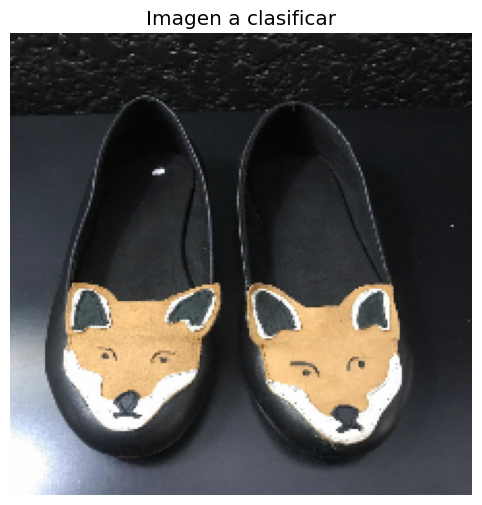

🔍 Comparando 6 modelos para la misma imagen...


🔍 Usando modelo: CNN Rápido
📝 Descripción: Red neuronal convolucional optimizada para velocidad

📊 Resultados de la clasificación:
🎯 Clase predicha: Fondo Inapropiado (Clase 0)
🎯 Confianza: 1.0000 (100.00%)

📈 Probabilidades por clase:
   Fondo Inapropiado (0): 1.0000 (100.00%)
   Fondo Apropiado (1): 0.0000 (0.00%)


🔍 Usando modelo: CNN Completo
📝 Descripción: Red neuronal convolucional con arquitectura completa


✅ Modelo CNN cargado: background_cnn_classifier_full.h5

📊 Resultados de la clasificación:
🎯 Clase predicha: Fondo Inapropiado (Clase 0)
🎯 Confianza: 0.9896 (98.96%)

📈 Probabilidades por clase:
   Fondo Inapropiado (0): 0.9896 (98.96%)
   Fondo Apropiado (1): 0.0104 (1.04%)


🔍 Usando modelo: Regresión Logística
📝 Descripción: Modelo de regresión logística con validación cruzada
✅ Modelo ML cargado: background_logistic_regression_classifier_cv.pkl
❌ Error en la clasificación: X has 50176 features, but StandardScaler is expecting 262144 features as input.
❌ Error con modelo background_logistic_regression_classifier_cv.pkl: X has 50176 features, but StandardScaler is expecting 262144 features as input.


🔍 Usando modelo: Random Forest Rápido
📝 Descripción: Random Forest optimizado para velocidad
✅ Modelo ML cargado: background_random_forest_classifier_features.pkl
❌ Error en la clasificación: X has 50176 features, but StandardScaler is expecting 12 features as input.
❌ Error con modelo 

In [16]:
# Comparar todos los modelos disponibles con una imagen de ejemplo
if available_models:
    try:
        # Usar la misma URL de ejemplo
        example_url = "https://http2.mlstatic.com/D_680853-MLM50014173158_052022-F.jpg"
        
        # Mostrar la imagen una sola vez
        print("🖼️ Imagen a clasificar:")
        image = load_image_from_url(example_url)
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title("Imagen a clasificar")
        plt.axis('off')
        plt.show()
        
        # Comparar modelos
        comparison_results = compare_models(example_url, available_models)
        
    except Exception as e:
        print(f"❌ Error en la comparación: {e}")
        print("💡 Tip: Verifica que tengas conexión a internet y que los modelos estén disponibles.")
else:
    print("❌ No hay modelos disponibles para comparar.")

## 7. Función Interactiva para Clasificación Personalizada

In [ ]:
def interactive_classification():
    """
    Función interactiva para clasificar imágenes personalizadas.
    """
    print("🎯 CLASIFICACIÓN INTERACTIVA DE IMÁGENES")
    print("="*50)
    
    # Listar modelos disponibles
    available_models = classifier.list_available_models()
    if not available_models:
        print("❌ No hay modelos disponibles. Ejecuta primero los scripts de entrenamiento.")
        return
    
    print("\n📋 Modelos disponibles:")
    for i, model in enumerate(available_models, 1):
        info = classifier.get_model_info(model)
        print(f"   {i}. {info['name']} ({info['type'].upper()})")
    
    # Seleccionar modelo
    try:
        model_choice = int(input("\n🔢 Selecciona el número del modelo a usar: ")) - 1
        if 0 <= model_choice < len(available_models):
            selected_model = available_models[model_choice]
        else:
            print("❌ Selección inválida. Usando el primer modelo.")
            selected_model = available_models[0]
    except ValueError:
        print("❌ Entrada inválida. Usando el primer modelo.")
        selected_model = available_models[0]
    
    print(f"\n✅ Modelo seleccionado: {classifier.get_model_info(selected_model)['name']}")
    
    # Seleccionar tipo de entrada
    print("\n📥 Tipo de entrada:")
    print("   1. URL de imagen")
    print("   2. Ruta de archivo local")
    
    try:
        input_type = int(input("\n🔢 Selecciona el tipo de entrada (1 o 2): "))
    except ValueError:
        print("❌ Entrada inválida. Usando URL por defecto.")
        input_type = 1
    
    # Obtener entrada de imagen
    if input_type == 1:
        image_input = input("\n🌐 Ingresa la URL de la imagen: ").strip()
        if not image_input:
            image_input = "https://http2.mlstatic.com/D_680853-MLM50014173158_052022-F.jpg"
            print(f"💡 Usando URL de ejemplo: {image_input}")
    else:
        image_input = input("\n📁 Ingresa la ruta del archivo: ").strip()
        if not image_input:
            print("❌ No se proporcionó ruta de archivo.")
            return
    
    # Realizar clasificación
    try:
        print(f"\n🔍 Clasificando imagen...")
        result = classify_image(image_input, selected_model, show_image=True)
        
        print(f"\n🎉 ¡Clasificación completada!")
        
    except Exception as e:
        print(f"❌ Error durante la clasificación: {e}")

print("✅ Función interactiva definida")
print("\n💡 Para usar la clasificación interactiva, ejecuta: interactive_classification()")

## 8. Ejecutar Clasificación Interactiva

In [ ]:
# Descomenta la siguiente línea para ejecutar la clasificación interactiva
# interactive_classification()

print("💡 Para usar la clasificación interactiva, descomenta la línea anterior y ejecuta la celda.")

## 9. Información Adicional y Consejos

In [ ]:
print("📚 INFORMACIÓN ADICIONAL")
print("="*50)

print("\n🎯 Interpretación de Resultados:")
print("   • Clase 0: Fondo Inapropiado (no blanco/crema)")
print("   • Clase 1: Fondo Apropiado (blanco/crema)")
print("   • Confianza: Probabilidad de que la predicción sea correcta")

print("\n🔧 Tipos de Modelos:")
print("   • CNN: Redes neuronales convolucionales (mejor para imágenes)")
print("   • ML: Modelos de machine learning tradicional (más rápidos)")

print("\n💡 Consejos de Uso:")
print("   • Los modelos CNN suelen ser más precisos para imágenes complejas")
print("   • Los modelos ML son más rápidos para procesamiento en lote")
print("   • Compara múltiples modelos para mayor confianza")
print("   • Las imágenes deben ser de productos en primer plano")

print("\n🚀 Funciones Disponibles:")
print("   • classify_image(image, model): Clasificar una imagen")
print("   • compare_models(image, models): Comparar múltiples modelos")
print("   • interactive_classification(): Modo interactivo")

print("\n📁 Estructura de Modelos:")
if models_dir.exists():
    model_files = list(models_dir.glob("*"))
    for model_file in model_files:
        size_mb = model_file.stat().st_size / (1024 * 1024)
        print(f"   • {model_file.name} ({size_mb:.1f} MB)")
else:
    print("   ❌ Directorio de modelos no encontrado")

print("\n✅ Notebook listo para usar!")